Authors: Joseph Curro, Nick Yielding

This is a fun Machine Learning example using a pretrained Artificial Neural Network (ANN) to classify some images 
of Joseph Curro's pet cats Artemis and Freya and Nick Yielding's pet dogs Coco and Sasha. The last layers of this ANN is then used to generate a heatmap superimposed
on the images to attempt to gain insight on what features of the image were most important to the ANN for the resulting
classification. This example is adapted from the Chollet book's chapter 5 examples.

In [9]:
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [10]:
# Careful with relative paths, but this makes a new absolute path from the relative
# os.getcwd() is current working directory, os.pardir is one dir up, then go down to img folder
img_in_folder = os.path.abspath(os.path.join(os.getcwd(),os.pardir,'img_in'))
img_out_folder = os.path.abspath(os.path.join(os.getcwd(),os.pardir,'img_out'))
# This makes a list of all files in the folder, expecting images
# It will break if you put something else in there, such as a sub folder 
# would need regex or glob library to make it safer
img_in_paths = os.listdir(img_in_folder)
print(img_in_folder)
print(img_out_folder)
print(img_in_paths)

/workspaces/eeng645-raylab/img_in
/workspaces/eeng645-raylab/img_out
['freya.jpg', 'Sasha2.jpg', 'Sasha1.jpg', 'Coco1.jpg', 'artemis.jpg', 'Coco2.jpg']


By using this method of finding the files, you can drop in other files and rerun this notebook to try it on other things!

In [13]:
# this is from Chollet Jupyter Notebooks Section 5.4
# Heat map of class activation
# The local path to our target image
# This is similar to the example in Section 5.4 from the Chollet book
tf.compat.v1.disable_eager_execution()
model = VGG16(weights='imagenet')

2024-01-23 23:25:05.387067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 23:25:05.387262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 23:25:05.387375: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Predicted for img freya.jpg: [('n02124075', 'Egyptian_cat', 0.15390308), ('n02096585', 'Boston_bull', 0.13677202), ('n03887697', 'paper_towel', 0.1267174)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


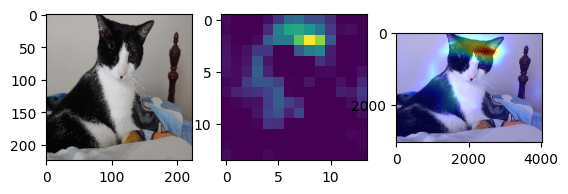

Predicted for img Sasha2.jpg: [('n02110185', 'Siberian_husky', 0.39852437), ('n02109961', 'Eskimo_dog', 0.31068084), ('n02091467', 'Norwegian_elkhound', 0.09483666)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


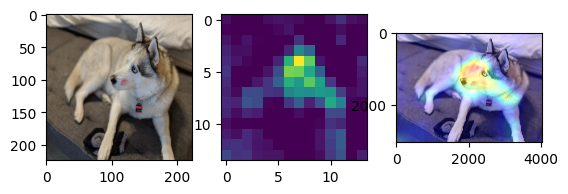

Predicted for img Sasha1.jpg: [('n02110185', 'Siberian_husky', 0.82976633), ('n02109961', 'Eskimo_dog', 0.1642487), ('n02110063', 'malamute', 0.005823127)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


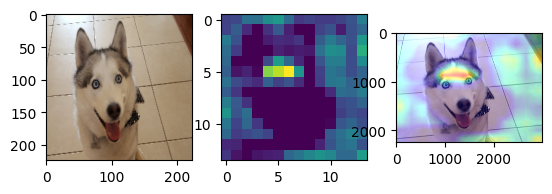

Predicted for img Coco1.jpg: [('n02110185', 'Siberian_husky', 0.86336374), ('n02110063', 'malamute', 0.07006989), ('n02109961', 'Eskimo_dog', 0.06645633)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


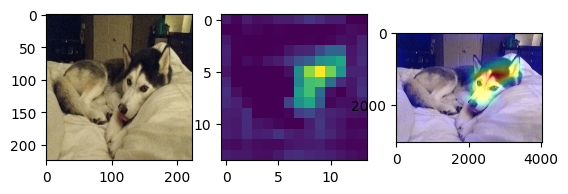

Predicted for img artemis.jpg: [('n02124075', 'Egyptian_cat', 0.6567105), ('n02105412', 'kelpie', 0.16046351), ('n02104365', 'schipperke', 0.09856404)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


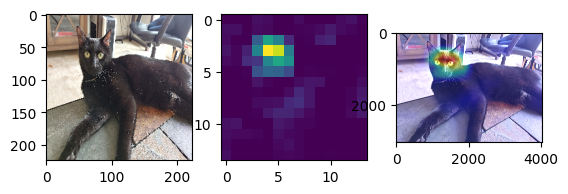

Predicted for img Coco2.jpg: [('n02110185', 'Siberian_husky', 0.69826597), ('n02109961', 'Eskimo_dog', 0.25588942), ('n02110063', 'malamute', 0.044868782)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


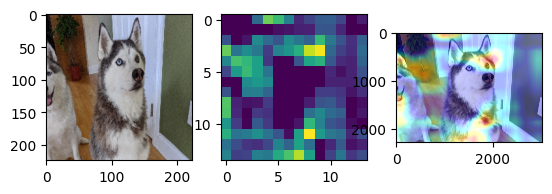

In [15]:
for img_file in img_in_paths:
    
    img = image.load_img(os.path.join(img_in_folder, img_file), target_size=(224, 224))

    x = image.img_to_array(img)
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(x / 255.)

    heatmap: np.ndarray = np.zeros((14, 14))
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)

    print(f'Predicted for img {img_file}:', decode_predictions(preds, top=3)[0])

    predicted_ouput = model.output[:, np.argmax(preds[0])]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(predicted_ouput, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input],
                            [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap / 255.)

    # We use cv2 to load the original image
    img = cv2.imread(os.path.join(img_in_folder, img_file))

    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.4 + img

    # for some reason the plot shows the colors backwards but the saved image does not. weird.
    # The weird slicing in imshow inverts the colors
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img[..., [2, 1, 0]] / 255.)

    # Save the image to disk
    cv2.imwrite(os.path.join(img_out_folder,f"heatmap_{img_file}"), superimposed_img)

    plt.show()